### Build and train the ResNeXT 50 and 101 network and retrain it by breast cancer data base

In [1]:
# the model has been developed and examined on the Google Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### import the liberaries

In [0]:
import torch
from torch import nn, optim
from torchvision import datasets ,transforms, models
import numpy as np
import matplotlib.pyplot as plt
import helper
import math
import time as evaltime
from torch import nn
from collections import OrderedDict
import tqdm
from tqdm import tqdm
import pandas as pd

In [ ]:
# if the GPU is available train from the GPU Otherwise, choose the CPU
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###  Load the pre trained model and change the FC layer to taylor the number of classes 2 and 8

In [3]:
# Donwload the pretrained model 
ResNext101_2c= models.resnext101_32x8d(pretrained=True)

# disable the parameters of the pre-trained model to be trained
for params in ResNext101_2c.parameters():
    params.required_grad=False

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [0]:
# adding three linear layer to the end of the model 
classifier= nn.Sequential(OrderedDict([
    ('0', nn.Linear(2048,1024)),
    ('1',nn.ReLU(inplace=True)),
    ('2', nn.Dropout(p=0.5)),
    ('3', nn.Linear(1024,1024)),
    ('4',nn.ReLU(inplace=True)),
    ('5', nn.Dropout(p=0.5)),
    ('6', nn.Linear(1024,2)),
    ('output', nn.LogSoftmax(dim=1))
    
]))
# add the classifier as the fc to the model 
ResNext101_2c.fc=classifier
# make the parameters to learn 
#In order to retrain the model, define the require grad true for all the parameters in the network.
for params in ResNext101_2c.fc.parameters():
    params.required_grad=True

### Define the loss and optimization. 

In [5]:
# using NLLLoss and adam as the loss function and optimization funcion, also learning rate set to 0.0002
critirion= nn.NLLLoss()
optimizer = optim.Adam(ResNext101_2c.parameters(), lr=0.0002)

# transfer the model to the GPU before training if there is any
ResNext101_2c.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1


### load the images to the train and test loader, with the ratio of 65/35

In [6]:
# set the locations 
dir_two_Classes='BreaKHis_v1/histology_slides/breast_cancer_images/'

dir_checkpoints='to_save_checkpoints/'
dir_statistics='to_save_statistics/'


# split the train and test datasets with the ration of 90/10
ratio=0.9
# Using the data augmentation techniques
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# save the datset
dataset= datasets.ImageFolder(dir_two_Classes,transform=train_transform)
# split the train and test sample based on the len 
train_sample_len=math.ceil(len(dataset)*ratio)
test_sample_len=len(dataset)-train_sample_len

# Using random split in the torch to split the images into train and test set
trainset,testset=torch.utils.data.random_split(dataset,[train_sample_len,test_sample_len] )

# Using dataloader for the train and test set and set the batch size into 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=4, shuffle=True)
testloader =torch.utils.data.DataLoader(testset, batch_size=1, num_workers=4, shuffle=False)

# In this work the number of classes are 2
classes=trainset.dataset.classes
# the number of images and the name of classes
print( len(dataset), classes)

7909 ['benign', 'malignant']


### Display an example of image out of all to be confirmed that the trainset is already loaded and Data augmentation has been applied 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


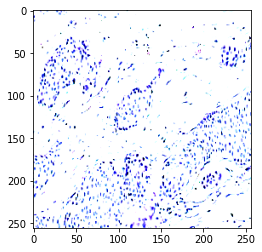

In [0]:
images=iter(testloader).next()
type(images)
images[0][0].shape
img=images[0][0].permute(1,2,0)

plt.imshow(img)

## Train the model

In [7]:
epochs = 100
steps= 0
print_every=100
running_loss=0
min_val_loss = np.Inf
results={'epoch':[],'training_loss':[], 'test_loss':[], 'test_accuracy':[], 'training_accuracy':[]}

for e in range(1,epochs+1):
  running_results={'loss':0, 'accuracy':0,'minutes':0,'steps':0}
  ResNext101_2c.train()
  train_bar=tqdm(trainloader)
  running_loss=0

  for images, labels in train_bar:
      start_time= evaltime.time()
      images, labels = images.to(device), labels.to(device)
      running_results['steps']+=1
      optimizer.zero_grad()
      output=ResNext101_2c.forward(images)
      ps=torch.exp(output)
      loss=critirion(output,labels)
      loss.backward()
      optimizer.step()
      # running_loss+=loss.item()
      running_results['loss']+=loss.item()
      equality = (ps.max(dim=1)[1]==labels.data)
      running_results['accuracy']+=equality.type(torch.FloatTensor).mean()
      train_bar.set_description(desc='[%d/%d], training_loss: %.4f, training_accuracy: %.4f '% 
                                (e,epochs, running_results['loss']/running_results['steps'],running_results['accuracy']/running_results['steps']))
  test_bar=tqdm(testloader, desc='Validation Results:')
  ResNext101_2c.eval()
  valing_results={'test_loss':0, 'test_accuracy':0, 'min_loss':0, 'steps':0}
  with torch.no_grad():
    for images, labels in test_bar: 
      valing_results['steps']+=1
      images, labels = images.to(device), labels.to(device)
      output=ResNext101_2c.forward(images)
      loss=critirion(output,labels)
      valing_results['test_loss']+= loss.item()
      ps=torch.exp(output)
      equality = (ps.max(dim=1)[1]==labels.data)
      valing_results['test_accuracy']+=equality.type(torch.FloatTensor).mean()
      test_bar.set_description(desc='test_loss: %.4f, test_accuracy: %.4f'%
                               (valing_results['test_loss']/valing_results['steps'], valing_results['test_accuracy']/valing_results['steps'] ))
    if (valing_results['test_loss']/valing_results['steps']< min_val_loss):
            min_val_loss=valing_results['test_loss']/valing_results['steps']
            print('saving the model with min loss of : '+ str(min_val_loss))
            torch.save(ResNext101_2c.state_dict(),dir_checkpoints+"dataaug_checkpoint_resnext101_32x8d_2c.pth")

     
  results['training_loss'].append(running_results['loss']/running_results['steps'])
  results['test_loss'].append(valing_results['test_loss']/valing_results['steps'])
  results['test_accuracy'].append(valing_results['test_accuracy'].item()/valing_results['steps'])
  results['training_accuracy'].append(running_results['accuracy'].item()/running_results['steps'])
  
  data_frame=pd.DataFrame(
        data={
            # 'Epoch':1,
            'Training_Loss':results['training_loss'],
            'Test_Loss': results['test_loss'],
            'Test_Accuracy':results['test_accuracy'],
            'Training_Accuracy':results['training_accuracy'],
           
                 },
        index=range(1,e+1)
    )
  data_frame.to_csv(dir_statistics+ 'dataaug_Resnext101_32x8d_eval_results.csv',  index_label="Epoch")    


[1/100], training_loss: 0.2839, training_accuracy: 0.8810 : 100%|██████████| 223/223 [10:13<00:00,  2.75s/it]
test_loss: 0.2524, test_accuracy: 0.8975: 100%|██████████| 790/790 [01:05<00:00, 12.00it/s]


saving the model with min loss of : 0.2524022615031351


[2/100], training_loss: 0.2093, training_accuracy: 0.9215 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.1991, test_accuracy: 0.9342: 100%|██████████| 790/790 [00:37<00:00, 21.21it/s]


saving the model with min loss of : 0.19910964396180986


[3/100], training_loss: 0.1737, training_accuracy: 0.9355 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.1348, test_accuracy: 0.9456: 100%|██████████| 790/790 [00:37<00:00, 21.26it/s]


saving the model with min loss of : 0.13475279083734826


[4/100], training_loss: 0.1388, training_accuracy: 0.9452 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.3532, test_accuracy: 0.8911: 100%|██████████| 790/790 [00:37<00:00, 21.32it/s]
[5/100], training_loss: 0.1225, training_accuracy: 0.9560 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.1138, test_accuracy: 0.9494: 100%|██████████| 790/790 [00:36<00:00, 21.36it/s]


saving the model with min loss of : 0.11384558477733708


[6/100], training_loss: 0.1081, training_accuracy: 0.9592 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.1357, test_accuracy: 0.9544: 100%|██████████| 790/790 [00:36<00:00, 21.50it/s]
[7/100], training_loss: 0.1098, training_accuracy: 0.9585 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0775, test_accuracy: 0.9658: 100%|██████████| 790/790 [00:36<00:00, 21.62it/s]


saving the model with min loss of : 0.0774945011621789


[8/100], training_loss: 0.0889, training_accuracy: 0.9671 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.3079, test_accuracy: 0.8937: 100%|██████████| 790/790 [00:36<00:00, 21.43it/s]
[9/100], training_loss: 0.0814, training_accuracy: 0.9697 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0952, test_accuracy: 0.9582: 100%|██████████| 790/790 [00:37<00:00, 21.24it/s]
[10/100], training_loss: 0.0802, training_accuracy: 0.9735 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.1531, test_accuracy: 0.9380: 100%|██████████| 790/790 [00:36<00:00, 21.48it/s]
[11/100], training_loss: 0.0685, training_accuracy: 0.9749 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0814, test_accuracy: 0.9696: 100%|██████████| 790/790 [00:36<00:00, 21.40it/s]
[12/100], training_loss: 0.0600, training_accuracy: 0.9767 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0512, test_accuracy: 0.9785: 100%|██████████| 790/790 [00:36<00:00

saving the model with min loss of : 0.05124427529075478


[13/100], training_loss: 0.0616, training_accuracy: 0.9781 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0746, test_accuracy: 0.9696: 100%|██████████| 790/790 [00:37<00:00, 20.83it/s]
[14/100], training_loss: 0.0494, training_accuracy: 0.9836 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.1256, test_accuracy: 0.9532: 100%|██████████| 790/790 [00:38<00:00, 20.77it/s]
[15/100], training_loss: 0.0499, training_accuracy: 0.9822 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.0545, test_accuracy: 0.9759: 100%|██████████| 790/790 [00:38<00:00, 20.74it/s]
[16/100], training_loss: 0.0465, training_accuracy: 0.9851 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.1141, test_accuracy: 0.9684: 100%|██████████| 790/790 [00:37<00:00, 21.24it/s]
[17/100], training_loss: 0.0527, training_accuracy: 0.9807 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0593, test_accuracy: 0.9810: 100%|██████████| 790/790 [00:37<00:

saving the model with min loss of : 0.048098419059680986


[22/100], training_loss: 0.0409, training_accuracy: 0.9849 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0909, test_accuracy: 0.9595: 100%|██████████| 790/790 [00:36<00:00, 21.45it/s]
[23/100], training_loss: 0.0460, training_accuracy: 0.9840 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0717, test_accuracy: 0.9709: 100%|██████████| 790/790 [00:36<00:00, 21.49it/s]
[24/100], training_loss: 0.0315, training_accuracy: 0.9893 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0750, test_accuracy: 0.9684: 100%|██████████| 790/790 [00:36<00:00, 21.41it/s]
[25/100], training_loss: 0.0343, training_accuracy: 0.9864 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0759, test_accuracy: 0.9658: 100%|██████████| 790/790 [00:36<00:00, 21.44it/s]
[26/100], training_loss: 0.0240, training_accuracy: 0.9907 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.3329, test_accuracy: 0.9544: 100%|██████████| 790/790 [00:37<00:

saving the model with min loss of : 0.041771308228939395


[28/100], training_loss: 0.0356, training_accuracy: 0.9891 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0454, test_accuracy: 0.9835: 100%|██████████| 790/790 [00:37<00:00, 21.15it/s]
[29/100], training_loss: 0.0196, training_accuracy: 0.9938 : 100%|██████████| 223/223 [04:07<00:00,  1.11s/it]
test_loss: 0.0710, test_accuracy: 0.9772: 100%|██████████| 790/790 [00:37<00:00, 21.23it/s]
[30/100], training_loss: 0.0265, training_accuracy: 0.9915 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.0814, test_accuracy: 0.9785: 100%|██████████| 790/790 [00:38<00:00, 20.34it/s]
[31/100], training_loss: 0.0211, training_accuracy: 0.9927 : 100%|██████████| 223/223 [04:09<00:00,  1.12s/it]
test_loss: 0.0860, test_accuracy: 0.9785: 100%|██████████| 790/790 [00:39<00:00, 19.81it/s]
[32/100], training_loss: 0.0221, training_accuracy: 0.9917 : 100%|██████████| 223/223 [04:09<00:00,  1.12s/it]
test_loss: 0.0482, test_accuracy: 0.9785: 100%|██████████| 790/790 [00:38<00:

saving the model with min loss of : 0.03903997947898092


[38/100], training_loss: 0.0229, training_accuracy: 0.9922 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0354, test_accuracy: 0.9861: 100%|██████████| 790/790 [00:38<00:00, 20.52it/s]


saving the model with min loss of : 0.03542448825474027


[39/100], training_loss: 0.0249, training_accuracy: 0.9903 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0459, test_accuracy: 0.9810: 100%|██████████| 790/790 [00:38<00:00, 20.69it/s]
[40/100], training_loss: 0.0185, training_accuracy: 0.9931 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.0622, test_accuracy: 0.9797: 100%|██████████| 790/790 [00:38<00:00, 20.78it/s]
[41/100], training_loss: 0.0230, training_accuracy: 0.9940 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.0409, test_accuracy: 0.9835: 100%|██████████| 790/790 [00:39<00:00, 19.78it/s]
[42/100], training_loss: 0.0159, training_accuracy: 0.9934 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0242, test_accuracy: 0.9886: 100%|██████████| 790/790 [00:38<00:00, 20.45it/s]


saving the model with min loss of : 0.024175855932356435


[43/100], training_loss: 0.0208, training_accuracy: 0.9922 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0728, test_accuracy: 0.9797: 100%|██████████| 790/790 [00:39<00:00, 20.24it/s]
[44/100], training_loss: 0.0257, training_accuracy: 0.9926 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0869, test_accuracy: 0.9772: 100%|██████████| 790/790 [00:38<00:00, 20.39it/s]
[45/100], training_loss: 0.0231, training_accuracy: 0.9923 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0559, test_accuracy: 0.9835: 100%|██████████| 790/790 [00:38<00:00, 20.28it/s]
[46/100], training_loss: 0.0223, training_accuracy: 0.9919 : 100%|██████████| 223/223 [04:08<00:00,  1.11s/it]
test_loss: 0.0667, test_accuracy: 0.9810: 100%|██████████| 790/790 [00:38<00:00, 20.39it/s]
[47/100], training_loss: 0.0304, training_accuracy: 0.9926 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0289, test_accuracy: 0.9873: 100%|██████████| 790/790 [00:38<00:

saving the model with min loss of : 0.01915584338616721


[81/100], training_loss: 0.0094, training_accuracy: 0.9975 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0443, test_accuracy: 0.9886: 100%|██████████| 790/790 [00:38<00:00, 20.29it/s]
[82/100], training_loss: 0.0241, training_accuracy: 0.9927 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0527, test_accuracy: 0.9823: 100%|██████████| 790/790 [00:39<00:00, 20.10it/s]
[83/100], training_loss: 0.0110, training_accuracy: 0.9968 : 100%|██████████| 223/223 [04:09<00:00,  1.12s/it]
test_loss: 0.0232, test_accuracy: 0.9924: 100%|██████████| 790/790 [00:39<00:00, 20.04it/s]
[84/100], training_loss: 0.0138, training_accuracy: 0.9962 : 100%|██████████| 223/223 [04:09<00:00,  1.12s/it]
test_loss: 0.0214, test_accuracy: 0.9924: 100%|██████████| 790/790 [00:39<00:00, 20.04it/s]
[85/100], training_loss: 0.0106, training_accuracy: 0.9969 : 100%|██████████| 223/223 [04:08<00:00,  1.12s/it]
test_loss: 0.0696, test_accuracy: 0.9823: 100%|██████████| 790/790 [00:39<00: